In [39]:
from Langgraph.configs import API_KEY, DEFAULT_MODEL
import os
import openai
from langgraph.graph import START, END, StateGraph, add_messages,MessagesState
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage,HumanMessage, BaseMessage
from langchain_core.runnables import Runnable 
from collections.abc import Sequence
from typing import Literal, Annotated

In [40]:
os.environ["OPENAI_API_KEY"] = API_KEY
openai.api_key = os.getenv('OPENAI_API_KEY')

In [41]:
my_list = add_messages([HumanMessage("Hi! I am Aniket"),
                        AIMessage("Hi Aniket, how may I assist you today?")],
                       [HumanMessage("Could you summarize today's news?")])

In [42]:
my_list

[HumanMessage(content='Hi! I am Aniket', additional_kwargs={}, response_metadata={}, id='ae080d52-da30-46e1-b74d-ff6a2f7fabf1'),
 AIMessage(content='Hi Aniket, how may I assist you today?', additional_kwargs={}, response_metadata={}, id='49009667-8cbd-48c2-841a-4663ceb958b6', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content="Could you summarize today's news?", additional_kwargs={}, response_metadata={}, id='723422af-2343-40eb-9fd6-9f2359ab6bad')]

In [43]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages] ##Annotated lets you attach a metadata to a type

# Here, when State Graph updates a field, it will use add_messages() to merge old and new values, rather than overwriting

add_messages is a Reducer function, It helps in combining the current state with the new incoming data in a structured way

In [44]:
chat = ChatOpenAI(model='gpt-4',
                 seed = 365,
                 temperature = 0,
                 max_completion_tokens = 100)

In [45]:
def ask_question(state: State) -> State:
    print("\n--------------> Entering Ask Question Node:")
    for i in state["messages"]:
        i.pretty_print()
    question = "What is your question?"
    print(question)
    return State(messages=[AIMessage(question), HumanMessage(input())])

def chatbot(state: State) -> State:
    print("\n--------------> Entering Chatbot:")
    
    for i in state["messages"]:
        i.pretty_print()
    response = chat.invoke(state['messages'])
    response.pretty_print()
    return State(messages=[response])
    
def ask_another_question(state: State) -> State:
    print("\n--------------> Entering Ask Another Question Node:")
    for i in state["messages"]:
        i.pretty_print()
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    return State(messages=[AIMessage(question), HumanMessage(input())])

In [46]:
def routing_function(state: State) -> Literal["ask_question","__end__"] :
    if state["messages"][-1].content == "yes":
        return "ask_question"
    else:
        return "__end__"

In [47]:
graph = StateGraph(State)
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function,)

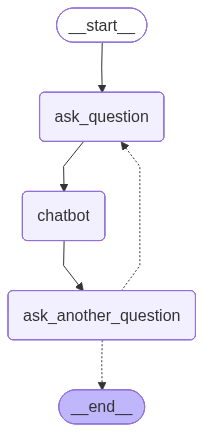

In [48]:
graph_compiled = graph.compile()
graph_compiled

In [31]:
graph_compiled.invoke(State(messages=[]))


--------------> Entering Ask Question Node:
What is your question?


 who was C V Raman?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who was C V Raman?
================================== Ai Message ==================================

C. V. Raman, or Chandrasekhara Venkata Raman, was an Indian physicist known for his work in the field of light scattering. He won the Nobel Prize for Physics in 1930 for his discovery, now known as Raman scattering or the Raman effect. This discovery has to do with the scattering of light and the change in its wavelength, which is used to study the effect of molecules on radiated energy. Raman was also the first Asian person to

--------------> Entering Ask Another Question Node:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who w

 yes



--------------> Entering Ask Question Node:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who was C V Raman?
================================== Ai Message ==================================

C. V. Raman, or Chandrasekhara Venkata Raman, was an Indian physicist known for his work in the field of light scattering. He won the Nobel Prize for Physics in 1930 for his discovery, now known as Raman scattering or the Raman effect. This discovery has to do with the scattering of light and the change in its wavelength, which is used to study the effect of molecules on radiated energy. Raman was also the first Asian person to
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
What is your ques

 where did he born?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who was C V Raman?
================================== Ai Message ==================================

C. V. Raman, or Chandrasekhara Venkata Raman, was an Indian physicist known for his work in the field of light scattering. He won the Nobel Prize for Physics in 1930 for his discovery, now known as Raman scattering or the Raman effect. This discovery has to do with the scattering of light and the change in its wavelength, which is used to study the effect of molecules on radiated energy. Raman was also the first Asian person to
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
===========================

 no


{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='cacde0d6-8af6-431e-9903-8705503d9d61', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='who was C V Raman?', additional_kwargs={}, response_metadata={}, id='ca03c058-db1a-4b42-9d74-2974fbcabb76'),
  AIMessage(content='C. V. Raman, or Chandrasekhara Venkata Raman, was an Indian physicist known for his work in the field of light scattering. He won the Nobel Prize for Physics in 1930 for his discovery, now known as Raman scattering or the Raman effect. This discovery has to do with the scattering of light and the change in its wavelength, which is used to study the effect of molecules on radiated energy. Raman was also the first Asian person to', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 23, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reaso

## MessagesState Class

In [33]:
def ask_question(state: MessagesState) -> MessagesState:
    print("\n--------------> Entering Ask Question Node:")
    for i in state["messages"]:
        i.pretty_print()
    question = "What is your question?"
    print(question)
    return MessagesState(messages=[AIMessage(question), HumanMessage(input())])

def chatbot(state: MessagesState) -> MessagesState:
    print("\n--------------> Entering Chatbot:")
    
    for i in state["messages"]:
        i.pretty_print()
    response = chat.invoke(state['messages'])
    response.pretty_print()
    return MessagesState(messages=[response])
    
def ask_another_question(state: MessagesState) -> MessagesState:
    print("\n--------------> Entering Ask Another Question Node:")
    for i in state["messages"]:
        i.pretty_print()
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    return MessagesState(messages=[AIMessage(question), HumanMessage(input())])

In [34]:
def routing_function(state: MessagesState) -> Literal["ask_question","__end__"] :
    if state["messages"][-1].content == "yes":
        return "ask_question"
    else:
        return "__end__"

In [35]:
graph_ms = StateGraph(MessagesState)
graph_ms.add_node("ask_question", ask_question)
graph_ms.add_node("chatbot", chatbot)
graph_ms.add_node("ask_another_question", ask_another_question)

graph_ms.add_edge(START, "ask_question")
graph_ms.add_edge("ask_question", "chatbot")
graph_ms.add_edge("chatbot", "ask_another_question")
graph_ms.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function,)

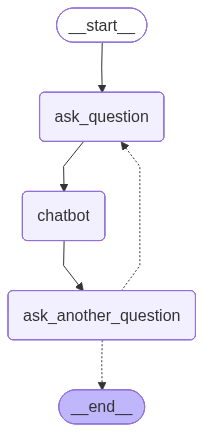

In [36]:
graph_ms_compiled = graph_ms.compile()
graph_ms_compiled

In [37]:
graph_ms_compiled.invoke(MessagesState(messages=[]))


--------------> Entering Ask Question Node:
What is your question?


 who are Duffer brothers?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who are Duffer brothers?
================================== Ai Message ==================================

The Duffer Brothers, Matt and Ross Duffer, are American film and television writers, directors, and producers. They are twins and are best known for creating the Netflix science fiction horror series "Stranger Things". They have also written and directed for the television series "Wayward Pines". The brothers have received several awards and nominations for their work on "Stranger Things", including a Screen Actors Guild Award and a nomination for a Golden Globe Award.

--------------> Entering Ask Another Question Node:
================================== Ai Message ==================================

What is your question?
================================ Human 

 yes



--------------> Entering Ask Question Node:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who are Duffer brothers?
================================== Ai Message ==================================

The Duffer Brothers, Matt and Ross Duffer, are American film and television writers, directors, and producers. They are twins and are best known for creating the Netflix science fiction horror series "Stranger Things". They have also written and directed for the television series "Wayward Pines". The brothers have received several awards and nominations for their work on "Stranger Things", including a Screen Actors Guild Award and a nomination for a Golden Globe Award.
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message ========

 where did they born?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who are Duffer brothers?
================================== Ai Message ==================================

The Duffer Brothers, Matt and Ross Duffer, are American film and television writers, directors, and producers. They are twins and are best known for creating the Netflix science fiction horror series "Stranger Things". They have also written and directed for the television series "Wayward Pines". The brothers have received several awards and nominations for their work on "Stranger Things", including a Screen Actors Guild Award and a nomination for a Golden Globe Award.
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message ==================

 no


{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='30a5e66f-c8d7-40c0-85d1-90806007f2db', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='who are Duffer brothers?', additional_kwargs={}, response_metadata={}, id='795064f3-6d22-4bc0-a0f5-ec6dcb2511ca'),
  AIMessage(content='The Duffer Brothers, Matt and Ross Duffer, are American film and television writers, directors, and producers. They are twins and are best known for creating the Netflix science fiction horror series "Stranger Things". They have also written and directed for the television series "Wayward Pines". The brothers have received several awards and nominations for their work on "Stranger Things", including a Screen Actors Guild Award and a nomination for a Golden Globe Award.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 22, 'total_tokens': 113, 'completion_tokens_details': {'accepted_p